In [1]:
#!pip install tensorflow
#!pip freeze

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


2022-01-29 11:00:07.337449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-29 11:00:07.374744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 11:00:07.556680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-29 11:00:07.556705: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you woul

In [2]:
#!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [3]:
# !pip install sklearn
# !pip install pandas


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np


In [5]:
# !wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'
# !wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla T4'

In [7]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [17]:
#!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

--2022-01-23 17:45:10--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  --.-KB/s    in 0.02s   

2022-01-23 17:45:11 (196 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [8]:
input_file = 'train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [9]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [10]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [11]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
42739,570e10d20b85d914000d7c9b,When was the first time humans visited Antarct...,"[Antarctica, has, no, indigenous, population, ...",19th century,18,19,False
42740,570e10d20b85d914000d7c9c,What was Antarctica presumed to be by the anci...,"[Antarctica, has, no, indigenous, population, ...",balance,39,39,False
42741,570e10d20b85d914000d7c9d,What did Ptolemy suggest that a southern land ...,"[Antarctica, has, no, indigenous, population, ...",symmetry,65,65,False
42742,570e10d20b85d914000d7c9e,Of what did early explores think Australia and...,"[Antarctica, has, no, indigenous, population, ...",Antarctica,94,94,False
42743,570e10d20b85d914000d7c9f,Early geographers thought that Antarctica was ...,"[Antarctica, has, no, indigenous, population, ...",larger,102,102,False
42744,5ad23535d7d075001a4287e0,When was Antarctica last seen by humans?,"[Antarctica, has, no, indigenous, population, ...",,-1,-1,True
42745,5ad23535d7d075001a4287e1,What is the vast continent in the far north?,"[Antarctica, has, no, indigenous, population, ...",,-1,-1,True
42746,5ad23535d7d075001a4287e2,Who suggested the idea of Terrs Australis in t...,"[Antarctica, has, no, indigenous, population, ...",,-1,-1,True
42747,5ad23535d7d075001a4287e3,What was discovered in the 1700's?,"[Antarctica, has, no, indigenous, population, ...",,-1,-1,True
42748,5ad23535d7d075001a4287e4,Who believed thet Antarctica was smaller then ...,"[Antarctica, has, no, indigenous, population, ...",,-1,-1,True


In [12]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [13]:
print_squad_sample(train_data)

CONTEXT: 
Everton F.C. is a limited company with the board of directors holding a majority
of the shares. The club's most recent accounts, from May 2014, show a net
total debt of £28.1 million, with a turnover of £120.5 million and a profit
of £28.2 million. The club's overdraft with Barclays Bank is secured against the Premier
League's "Basic Award Fund", a guaranteed sum given to clubs for competing in the
Premier League. Everton agreed a long-term loan of £30 million with Bear Stearns and
Prudential plc in 2002 over the duration of 25 years; a consolidation of debts
at the time as well as a source of capital for new player acquisitions.
Goodison Park is secured as collateral.
QUESTION:                                                                                            ANSWER:
Who holds a majority of the shares in the Everton FC?                                                the board of directors
What is the Everton FC's overdraft with Barclays Bank secured against?         

In [14]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
45704,5710dcb5b654c5140001fa0e,Who criticized the sciences for distancing man...,"[Broadly, speaking,, Enlightenment, science, g...",Rousseau,65,65,False,212,100
26954,56f9f63b8f12f31900630013,What do stiffness and elastic strength depend ...,"[Knots, do, not, necessarily, influence, the, ...",sound wood,27,28,False,55,67
129457,5ace6bea32bba1001ae4a64c,What did deer stalking originally aim to protect?,"[Unarmed, fox, hunting, on, horseback, with, h...",,-1,-1,True,172,49
48394,5acf9c8b77cf76001a6854c1,Who refused to hand over power to Muawiyah?,"[Ali, was, assassinated, in, 661, by, a, Khari...",,-1,-1,True,139,43
14852,5acf87db77cf76001a685128,What picture books from the 17th century don't...,"[Japanese, comics, and, cartooning, (manga),[g...",,-1,-1,True,56,66


In [15]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 32

In [18]:
cached_features_file="cache_train"

In [21]:
if not os.path.exists(cached_features_file):
    features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
    torch.save(features, cached_features_file)
else:
    features = torch.load(cached_features_file)

In [22]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [23]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [24]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [25]:
import glob
checkpoints = sorted(glob.glob('checkpoints/checkpoint*-[0-9]*'))

In [25]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [27]:
if len(checkpoints) > 0:
    global_step = checkpoints[-1].split('-')[-1]
    ckpt_name = 'checkpoints/checkpoint-{}'.format(global_step)
    print("Loading model from checkpoint %s" % ckpt_name)
    model = BertForQuestionAnswering.from_pretrained(ckpt_name)
    train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
    train_loss_set = to_list(train_loss_set_ckpt)
    tr_loss = train_loss_set[-1]
else:
    global_step = 0
    train_loss_set = []
    tr_loss = 0.0
    model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [28]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0274, -0.0550, -0.0125,  ...,  0.0254,  0.0244,  0.0132],
        [ 0.0032,  0.0042, -0.0118,  ..., -0.0006,  0.0169, -0.0281]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [29]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoints/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 32
  Total optimization steps = 4508


Iteration:   0%|                                                                                                                                                                   | 0/4508 [00:00<?, ?it/s]/home/rohit/anaconda3/envs/transformer/lib/python3.9/site-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:   2%|██▌                                                                                                                                                     | 75/4508 [01:41<1:43:11,  1.40s/it]


Iteration:   3%|█████                                                                                                                                                  | 153/4508 [03:32<1:45:07,  1.45s/it]


Iteration:   5%|███████▋                                                                                                                                               | 231/4508 [05:25<1:43:56,  1.46s/it]


Iteration:   7%|██████████▎                                                                                                                                            | 309/4508 [07:19<1:41:59,  1.46s/it]


Iteration:   9%|████████████▉                                                                                                                                          | 387/4508 [09:13<1:40:21,  1.46s/it]


Iteration:  10%|███████████████▌                                                                                                                                       | 465/4508 [11:07<1:37:47,  1.45s/it]


Iteration:  12%|██████████████████▏                                                                                                                                    | 543/4508 [13:00<1:36:43,  1.46s/it]


Iteration:  14%|████████████████████▊                                                                                                                                  | 621/4508 [14:55<1:35:05,  1.47s/it]


Iteration:  16%|███████████████████████▍                                                                                                                               | 699/4508 [16:49<1:32:31,  1.46s/it]


Iteration:  17%|██████████████████████████                                                                                                                             | 777/4508 [18:43<1:31:07,  1.47s/it]


Iteration:  19%|████████████████████████████▋                                                                                                                          | 855/4508 [20:38<1:29:24,  1.47s/it]


Iteration:  21%|███████████████████████████████▎                                                                                                                       | 933/4508 [22:32<1:27:13,  1.46s/it]


Iteration:  22%|████████████████████████████████▌                                                                                                                      | 973/4508 [23:30<1:26:31,  1.47s/it]

Iteration:  24%|████████████████████████████████████▏                                                                                                                 | 1086/4508 [26:17<1:23:32,  1.46s/it]


Iteration:  26%|██████████████████████████████████████▋                                                                                                               | 1164/4508 [28:11<1:21:56,  1.47s/it]


Iteration:  28%|█████████████████████████████████████████▎                                                                                                            | 1242/4508 [30:06<1:20:11,  1.47s/it]


Iteration:  29%|███████████████████████████████████████████▉                                                                                                          | 1320/4508 [32:01<1:18:27,  1.48s/it]


Iteration:  31%|██████████████████████████████████████████████▌                                                                                                       | 1398/4508 [33:56<1:16:33,  1.48s/it]


Iteration:  33%|█████████████████████████████████████████████████                                                                                                     | 1476/4508 [35:51<1:14:04,  1.47s/it]


Iteration:  34%|███████████████████████████████████████████████████▋                                                                                                  | 1554/4508 [37:45<1:11:35,  1.45s/it]


Iteration:  36%|██████████████████████████████████████████████████████▎                                                                                               | 1632/4508 [39:38<1:09:29,  1.45s/it]


Iteration:  38%|████████████████████████████████████████████████████████▉                                                                                             | 1710/4508 [41:31<1:07:42,  1.45s/it]


Iteration:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 1788/4508 [43:24<1:05:46,  1.45s/it]


Iteration:  41%|██████████████████████████████████████████████████████████████                                                                                        | 1866/4508 [45:17<1:03:45,  1.45s/it]


Iteration:  43%|████████████████████████████████████████████████████████████████▋                                                                                     | 1944/4508 [47:10<1:02:03,  1.45s/it]


Iteration:  44%|██████████████████████████████████████████████████████████████████▌                                                                                   | 2000/4508 [48:32<1:00:42,  1.45s/it]

Train loss: 1.4239754182398319



Iteration:  44%|██████████████████████████████████████████████████████████████████▌                                                                                   | 2001/4508 [48:34<1:09:56,  1.67s/it]

Saving model checkpoint to checkpoints/checkpoint-2000



Iteration:  46%|██████████████████████████████████████████████████████████████████████                                                                                  | 2079/4508 [50:27<58:47,  1.45s/it]


Iteration:  48%|████████████████████████████████████████████████████████████████████████▋                                                                               | 2157/4508 [52:20<56:57,  1.45s/it]


Iteration:  50%|███████████████████████████████████████████████████████████████████████████▎                                                                            | 2235/4508 [54:14<55:05,  1.45s/it]


Iteration:  51%|█████████████████████████████████████████████████████████████████████████████▉                                                                          | 2313/4508 [56:07<53:19,  1.46s/it]


Iteration:  53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2391/4508 [58:01<51:09,  1.45s/it]


Iteration:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2469/4508 [59:54<49:17,  1.45s/it]


Iteration:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2547/4508 [1:01:47<47:31,  1.45s/it]


Iteration:  58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2625/4508 [1:03:41<45:38,  1.45s/it]


Iteration:  60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2703/4508 [1:05:34<43:48,  1.46s/it]


Iteration:  61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2731/4508 [1:06:15<43:06,  1.46s/it]

In [ ]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [12]:
train_loss_set_ckpt = torch.load('checkpoints/checkpoint-1000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

In [14]:
!pip install matplotlib

     |████████████████████████████████| 11.2 MB 33.4 MB/s eta 0:00:01
     |████████████████████████████████| 890 kB 98.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 99.8 MB/s eta 0:00:01


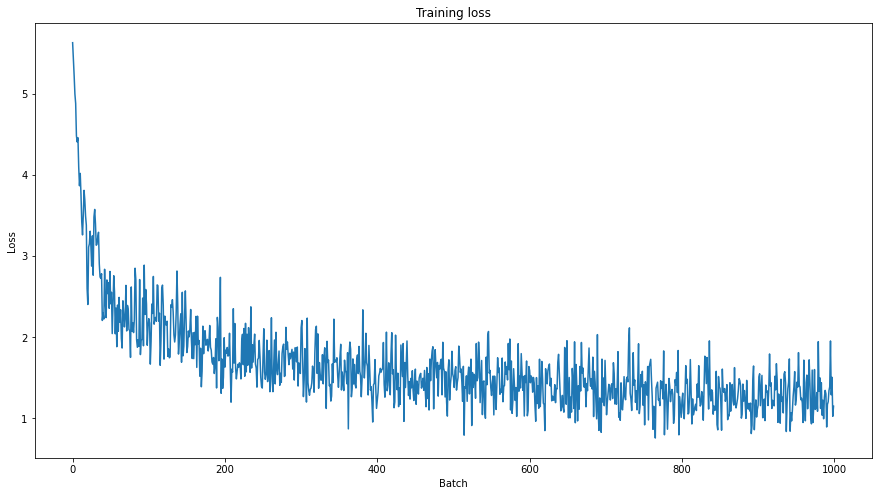

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [19]:
input_file = 'dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [20]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [21]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [22]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = 'dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "predictions.json"
  output_nbest_file = "nbest_predictions.json"
  output_null_log_odds_file = "null_odds.json"
  output_dir = "predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [23]:
model = BertForQuestionAnswering.from_pretrained("checkpoints/checkpoint-1000").to(device)

In [26]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 32


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [03:30<00:00,  2.01it/s]


{
  "exact": 54.92293438894972,
  "f1": 59.3681815959742,
  "total": 11873,
  "HasAns_exact": 68.33670715249663,
  "HasAns_f1": 77.23994940772602,
  "HasAns_total": 5928,
  "NoAns_exact": 41.5475189234651,
  "NoAns_f1": 41.5475189234651,
  "NoAns_total": 5945,
  "best_exact": 64.81091552261434,
  "best_exact_thresh": -4.220971584320068,
  "best_f1": 67.46601147147814,
  "best_f1_thresh": -3.4128596782684326
}


In [27]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 54.92293438894972}, {'f1': 59.3681815959742}, {'total': 11873}, {'HasAns_exact': 68.33670715249663}, {'HasAns_f1': 77.23994940772602}, {'HasAns_total': 5928}, {'NoAns_exact': 41.5475189234651}, {'NoAns_f1': 41.5475189234651}, {'NoAns_total': 5945}, {'best_exact': 64.81091552261434}, {'best_exact_thresh': -4.220971584320068}, {'best_f1': 67.46601147147814}, {'best_f1_thresh': -3.4128596782684326}]


In [28]:
# input_file = 'train-v2.0.json'
# examples = read_squad_examples(input_file=input_file,
#                                 is_training=True,
#                                 version_2_with_negative=True)

In [30]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [32]:
with open("predictions.json") as f:
    lines = f.readlines() 

print("Document: ", (" ".join(val_examples[0].__dict__["doc_tokens"])))
print("\n\n")
for index, each in enumerate(val_examples[:5]):
  print(f"question_text: {each.question_text} \nPredicted Answer: {(lines[index+1].split(':')[1])}")

Document:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.



question_text: In what country is Normandy located? 
Predicted Answer:  "France",

question_text: When were the Normans in Normandy? 
Predicted Answer:  "10th and 11th centuries",

question_text: From which countries did the Norse originate? 
